## 🔮 Deep Learning in Practice


### Have Considered PyTorch


Only as a tensor library (i.e., like Numpy) but which also offers GPU support and automatic differentiation


<img src="https://i.imgur.com/FXSdMjM.png" />


<table>
  <tr> <th>torch</th> <th>torch.nn</th> <th>torch.nn.functional</th> <th>torch.optim</th> <th>torch.utils</th> </tr>
  <tr> 
  <td> Wraps all other modules and offers tensor functionality on GPU and automatic differentiation </td> 
  <td> Basic blocks of neural networks (i.e., layers, activations and loss functions) </td> 
  <td> Stateless functional version of (torch.nn) </td> 
  <td> Optimization algorithms and learning rate schedulers</td> 
  <td> reading data, batching, logging, etc. </td> </tr>
</table>


Aside from these modules, PyTorch also made other libraries such as `torchvision`, `torchtext` and `torchaudio`. These in general provide **transformations** specific to the data type (e.g., rotation for images, pitch shift for audio, tokenization for text) as well as built-in known datasets and models.

It's obvious we're done with the main module `torch` since last tutorial, let's explore the rest:

### 📊 Loading Data

Let's look into `torch.utils.data`

With PyTorch, you must start wrap your data in a `Dataset` object:

In [2]:
import torch
from torch.utils.data import TensorDataset, random_split, DataLoader

x_data = torch.tensor([
    [0.3, 2.1, 3.3, 4.2, 3.5],
    [1.4, 2.5, 3.6, 4.1, 5.5], 
    [1.2, 2.1, 3.4, 0.4, 5.9], 
    [0.2, 2.1, 7.4, 0.4, 5.9], 
    [1.3, 6.1, 3.4, 1.4, 2.9], 
    ])
y_data = torch.tensor([0, 1, 0, 1, 0])
# obvious fact: x and y can come from numpy arrays

dataset = TensorDataset(x_data, y_data)
print("first example of dataset:", dataset[0], " where dataset is of length:", len(dataset))

first example of dataset: (tensor([0.3000, 2.1000, 3.3000, 4.2000, 3.5000]), tensor(0))  where dataset is of length: 5


And split it into different sets if needed

In [3]:
# Split the dataset randomly into training and validation sets
train_dataset, val_dataset = random_split(dataset, [0.8, 0.2])
print(f"now the train dataset is of length: {len(train_dataset)} and the validation dataset is of length: {len(val_dataset)}")

now the train dataset is of length: 4 and the validation dataset is of length: 1


Once we have our `Dataset` object, you can use `DataLoader` which for FREE gives you:

- Automatic batching and random sampling 

- Multiprocessing data loading and memory pinning

In [4]:
batch_size = 2
train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True,
                          sampler=None,                     # We will get back to this later
                          num_workers=0
                          )

val_loader = DataLoader(val_dataset, 
                        batch_size=batch_size, 
                        shuffle=False,
                        sampler=None,
                        num_workers=0
                        )

The object it returns is a non-indexable iterable (i.e., can loop on it but not index it).

In [6]:
for i, (inputs, targets) in enumerate(train_loader):
    print("Batch Number:", i)
    print("Inputs:", inputs)
    print("Targets:", targets)
    if i == 1: break

Batch Number: 0
Inputs: tensor([[1.4000, 2.5000, 3.6000, 4.1000, 5.5000],
        [1.3000, 6.1000, 3.4000, 1.4000, 2.9000]])
Targets: tensor([1, 0])
Batch Number: 1
Inputs: tensor([[0.3000, 2.1000, 3.3000, 4.2000, 3.5000],
        [1.2000, 2.1000, 3.4000, 0.4000, 5.9000]])
Targets: tensor([0, 0])


#### Back to Datasets

However, most datasets you will come across will be unstructured and locally stored (i.e., `TensorDataset` not so helpful). 

**Generic Solution:** 

Just make a class that loads your dataset and inherit the `Dataset` class from `PyTorch`. 

```Python
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, params):
        pass

    def __len__(self):                      # Condition 1: must have length
        pass

    def __getitem__(self, idx):             # Condition 2: and be indexable
        pass
```

Now instead of `dataset = TensorDataset(x_data, y_data)` we will do `dataset = CustomDataset(params)` and implement the methods and the rest will just work!

Let's see a basic example. Want to load Sklearn datasets into PyTorch while side stepping any type or format conversions (as these aren't always possible).

In [5]:
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.datasets import load_iris, load_digits
from sklearn.preprocessing import StandardScaler

class ClassicDataset(Dataset):
    def __init__(self, type='iris'):
        sklean_dataset = load_iris() if type=='iris' else load_digits()
        self.data = sklean_dataset.data
        self.targets = sklean_dataset.target

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.targets[idx]

        return (x, y)

# Example usage:
iris_dataset = ClassicDataset(type="iris")                              # hyperparameters allowed!
train_dataset, val_dataset = random_split(iris_dataset , [0.8, 0.2])
train_dataloader = DataLoader(train_dataset, batch_size=12, shuffle=True)
for (xb, yb) in train_dataloader:
    print(xb)
    print(yb)
    break

tensor([[5.5000, 2.4000, 3.8000, 1.1000],
        [4.8000, 3.0000, 1.4000, 0.3000],
        [6.0000, 3.4000, 4.5000, 1.6000],
        [5.9000, 3.0000, 5.1000, 1.8000],
        [6.4000, 3.1000, 5.5000, 1.8000],
        [6.0000, 3.0000, 4.8000, 1.8000],
        [6.0000, 2.9000, 4.5000, 1.5000],
        [6.7000, 3.3000, 5.7000, 2.5000],
        [4.8000, 3.4000, 1.9000, 0.2000],
        [5.0000, 3.5000, 1.3000, 0.3000],
        [7.4000, 2.8000, 6.1000, 1.9000],
        [6.7000, 3.0000, 5.0000, 1.7000]], dtype=torch.float64)
tensor([1, 0, 1, 2, 2, 2, 1, 2, 0, 0, 2, 1])


Less generally, `torchvision`, `torchaudio` or `torchtext` may have already implemented common custom datasets:

<img src="https://i.imgur.com/PvLR9So.png" width="1100">

And they allow transformations! Let's look at:

- [Torch Vision Transforms](https://pytorch.org/vision/0.9/transforms.html)

- [Torch Audio Transforms](https://pytorch.org/audio/stable/transforms.html)

- [Torch Text Transforms](https://pytorch.org/text/stable/transforms.html)

In [ ]:
from torchvision import datasets, transforms        #models has some pretrained models. 


train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),      #crop a random (within limits) piece and resize to 224x224.
        transforms.RandomHorizontalFlip(),      #By default 50% chance to flip the image horizontally.
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5) , (0.25, 0.25, 0.25))
    ])


val_transforms = transforms.Compose([
        transforms.Resize(256),                 #simply resize the image
        transforms.CenterCrop(224),             #center crop of size 244x244
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5) , (0.25, 0.25, 0.25))
    ])

train_data = datasets.ImageFolder('./data/Hymenoptera/train', train_transforms)
val_data = datasets.ImageFolder('./data/Hymenoptera/val', val_transforms)

Download from [here](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).

And as we said earlier, each of [torchvision](https://pytorch.org/vision/stable/datasets.html), [torchaudio](https://pytorch.org/audio/stable/datasets.html) and [torchtext](https://pytorch.org/text/stable/datasets.html) also tend to come with many popular built-in datasets. Click links to have a look and let's try one out now!

In [9]:
import torchaudio
commands_data = torchaudio.datasets.CMUARCTIC(root='.', download=True)      # Speech dataset from CMU

100%|██████████| 89.0M/89.0M [00:06<00:00, 13.4MB/s]


The last main component of [torchvision](https://pytorch.org/vision/0.9/models.html), [torchaudio](https://pytorch.org/audio/stable/models.html) and [torchtext](https://pytorch.org/text/stable/models.html) are pretrained models. We can have a look at some of them now but we will try them out later. Note that the `HuggingFace` library, rather `torchtext` dominates the area of NLP pretrained models.

#### Back to Samplers

In PyTorch, samplers define how indices are drawn from a dataset when loading batches. They are mainly used in DataLoader to control batch composition.

In [7]:
import torch
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler

# Simulated dataset: 2D feature vectors
data = torch.tensor([
    [1.0, 2.0], [2.0, 3.0], [3.0, 4.0], [4.0, 5.0], [5.0, 6.0], [6.0, 7.0],  # Class 0
    [10.0, 20.0], [20.0, 30.0]                                               # Class 1 (minority)
])
labels = torch.tensor([0, 0, 0, 0, 0, 0, 1, 1])                              # Imbalanced: 6 class-0, 2 class-1

# Repeat data and labels to create a larger dataset
data_large = data.repeat(10, 1)
labels_large = labels.repeat(10)

# Compute weights: inverse of class frequency
class_counts = torch.bincount(labels_large)                                        # e.g., tensor([60, 20])
class_weights = 1.0 / class_counts.float()                                         # More weight for minority class
sample_weights = class_weights[labels_large]                                       # Map each label to its weight (0->1/60, 1->1/20)

# Define sampler
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# DataLoader with the sampler
dataset = TensorDataset(data_large, labels_large)
loader = DataLoader(dataset, batch_size=4, sampler=sampler)

# Print sampled batches
for batch in loader:
    print(batch)

[tensor([[10., 20.],
        [ 4.,  5.],
        [20., 30.],
        [20., 30.]]), tensor([1, 0, 1, 1])]
[tensor([[20., 30.],
        [10., 20.],
        [ 3.,  4.],
        [ 6.,  7.]]), tensor([1, 1, 0, 0])]
[tensor([[10., 20.],
        [ 6.,  7.],
        [20., 30.],
        [ 3.,  4.]]), tensor([1, 0, 1, 0])]
[tensor([[ 3.,  4.],
        [ 2.,  3.],
        [10., 20.],
        [20., 30.]]), tensor([0, 0, 1, 1])]
[tensor([[10., 20.],
        [ 2.,  3.],
        [ 6.,  7.],
        [ 4.,  5.]]), tensor([1, 0, 0, 0])]
[tensor([[ 4.,  5.],
        [20., 30.],
        [ 1.,  2.],
        [20., 30.]]), tensor([0, 1, 0, 1])]
[tensor([[10., 20.],
        [10., 20.],
        [10., 20.],
        [ 1.,  2.]]), tensor([1, 1, 1, 0])]
[tensor([[ 5.,  6.],
        [10., 20.],
        [ 2.,  3.],
        [20., 30.]]), tensor([0, 1, 0, 1])]
[tensor([[20., 30.],
        [ 3.,  4.],
        [10., 20.],
        [ 1.,  2.]]), tensor([1, 0, 1, 0])]
[tensor([[ 4.,  5.],
        [ 2.,  3.],
        [10., 

By default, when `shuffle=True` in the dataloader, it will use a `RandomSampler` and if it's false, it will use `SequentialSampler`. These PyTorch samplers define how to draw one example of a batch and this process is repeated to construct a batch. It is surely possible to implement a custom sampler in PyTorch.

#### 🧠 Let's Recap

- Must wrap dataset in a PyTorch `Dataset` object (from `torch.utils`)

- Covered `Dataset` forming whether directly through tensors, custom dataset or helper libraries

- Covered the need to wrap data in `Dataset` to be able to use `Dataloader` and how `Sampler`s help with batch composition

- Saw that PyTorch helper libraries also offer built-in datasets, transformations and models.

The rest of [torch.utils](https://pytorch.org/docs/stable/utils.html) is niche but we may explore more of it later. 

Before we move on let's discuss how we represent different unstructured data as tensors in deep learning.

<table>
<tr>
<th> Table </th> <th> Images </th> <th> Audio </th> <th> Text </th>
<tr>
<td> Each observation already a vector </td> 
<td> 

Each observation is some $(l,w,3)$ tensor 

</td> 
<td> 

Initially sequence of amplitudes (discrete signal) and typically converted to frequency domain $(n_w,w)$ (e.g., [Mel Spectrogram](https://commons.wikimedia.org/wiki/File:Spektogram_Vokale.png)) 

</td> 
<td> 

Statistical or deep learning approaches to assign word/sentence to a [meaningful vector](https://community.sap.com/t5/technology-blogs-by-members/vector-databases-and-embeddings-revolutionizing-ai-in-rag-in-llm-or-gpt/ba-p/13575985)  

</td>
</table>

We may see some examples soon.

<img src="https://i.imgur.com/TEFUEow.png">

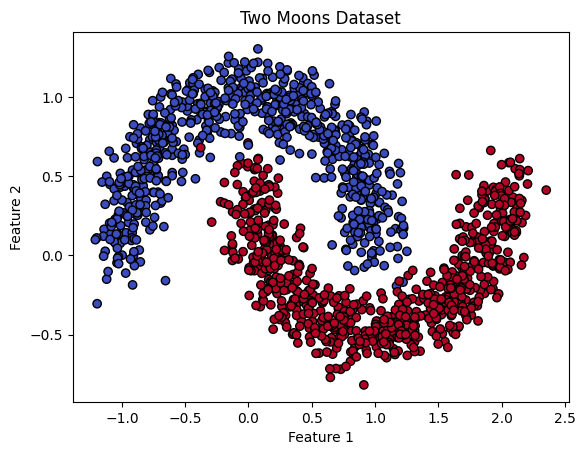

In [11]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

# Generate moon-shaped dataset
X, y = make_moons(n_samples=1400, noise=0.13, random_state=42)

# Plot the dataset
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolors='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Two Moons Dataset")
plt.show()
